##ResNet50

- SMOTE technique applied
- ResNet50(weights='imagenet') - with imagenet weights
- IMG_SIZE = 32
- BATCH_SIZE = 32
- EPOCHS = 30
- Lr = 0.0001

##Findings:
Accuracy: 93.48%

#Mount Google Drive and import libraries

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models

Mounted at /content/drive


#Dataset:

##Load training data

In [ ]:
# Define paths to dataset directories
train_dir = '/content/drive/My Drive/Data/GTSRB/Train/GTSRB/Final_Training/Images/'
test_dir = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/'

# Define image size
IMG_SIZE = 32  # Resize images
BATCH_SIZE = 32
num_classes = 43

# Helper function to load images and labels
def load_data(data_dir):
    images = []
    labels = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    # Loop through each subdirectory (which corresponds to a class)
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)

        if os.path.isdir(label_path):
            label = int(label_dir)  # Subdirectory name is the class label

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Check if the file has a valid image extension
                _, file_extension = os.path.splitext(img_file)
                if file_extension.lower() not in valid_extensions:
                    print(f"Skipping non-image file: {img_file}")
                    continue  # Skip non-image files (e.g., CSV)

                # Read the image using OpenCV
                image = cv2.imread(img_path)

                # Resize image
                image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

                # Append the image and label to the lists
                images.append(image)
                labels.append(label)

    # Convert to NumPy arrays and normalize
    images = np.array(images, dtype='float32') / 255.0  # Normalize images
    labels = to_categorical(labels, num_classes)  # One-hot encode labels

    return images, labels

# Load training data
images, labels = load_data(train_dir)

Skipping non-image file: GT-00000.csv
Skipping non-image file: GT-00001.csv
Skipping non-image file: GT-00002.csv
Skipping non-image file: GT-00003.csv
Skipping non-image file: GT-00004.csv
Skipping non-image file: GT-00005.csv
Skipping non-image file: GT-00006.csv
Skipping non-image file: GT-00007.csv
Skipping non-image file: GT-00008.csv
Skipping non-image file: GT-00009.csv
Skipping non-image file: GT-00010.csv
Skipping non-image file: GT-00011.csv
Skipping non-image file: GT-00012.csv
Skipping non-image file: GT-00013.csv
Skipping non-image file: GT-00014.csv
Skipping non-image file: GT-00015.csv
Skipping non-image file: GT-00016.csv
Skipping non-image file: GT-00017.csv
Skipping non-image file: GT-00018.csv
Skipping non-image file: GT-00019.csv
Skipping non-image file: GT-00020.csv
Skipping non-image file: GT-00021.csv
Skipping non-image file: GT-00022.csv
Skipping non-image file: GT-00023.csv
Skipping non-image file: GT-00024.csv
Skipping non-image file: GT-00025.csv
Skipping non

##SMOTE
Applying Synthetic Minority Oversampling Technique (SMOTE) to over-sample the classes which are under-represented.

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

train_rows=len(images)
images = images.reshape(train_rows,-1)

images, labels = sm.fit_resample(images, labels)
images = images.reshape(-1,32,32,3)

In [ ]:
print(images.shape)
print(labels.shape)

(96750, 32, 32, 3)
(96750, 43)


## Split dataset into train and validation set

In [ ]:
train_images, train_labels = images, labels

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')

Training data shape: (77400, 32, 32, 3)
Validation data shape: (19350, 32, 32, 3)


## Visualization of some images

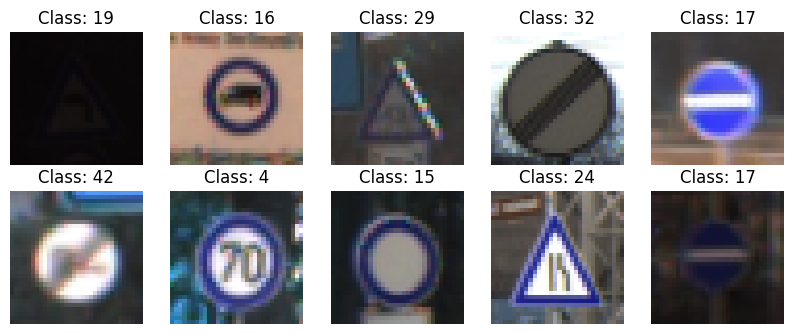

In [ ]:
import matplotlib.pyplot as plt

# Function to plot images
def plot_images(images, labels, num=10):
    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.show()

# Plot training images
plot_images(X_train, y_train)

##Data Transformation

In [ ]:
### Image Augmentation ###
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=15,        # Rotate images by up to 15 degrees
    zoom_range=0.2,           # Random zoom in/out by up to 20%
    width_shift_range=0.1,    # Shift the image horizontally by 10%
    height_shift_range=0.1,   # Shift the image vertically by 10%
    #horizontal_flip=True,     # Randomly flip images horizontally
)

# Fit the generator on the training data
datagen.fit(X_train)

# Create the augmented data generator for training
train_generator = datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)

##Visualization of Augmented Images

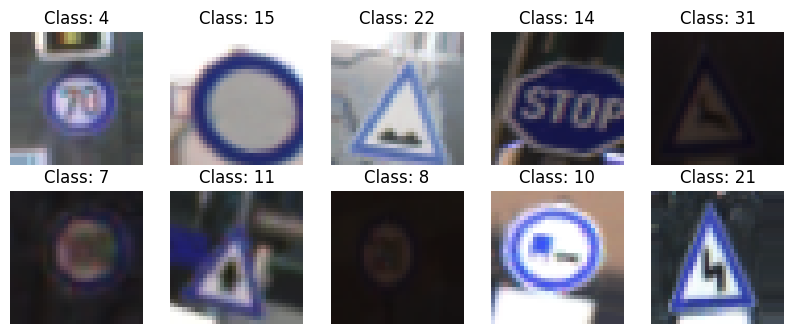

In [ ]:
import matplotlib.pyplot as plt

# Visualize some augmented images
augmented_images, augmented_labels = next(train_generator)

# Plot some examples
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f'Class: {np.argmax(augmented_labels[i])}')
    plt.axis('off')
plt.show()

## Load test data

In [ ]:
# Load the test dataset
def load_test_data(test_dir):
    images = []
    img_names = []

    # Valid image file extensions
    valid_extensions = ['.jpg', '.jpeg', '.png', '.ppm']

    for img_file in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_file)

        # Check if the file is an image
        _, file_extension = os.path.splitext(img_file)
        if file_extension.lower() not in valid_extensions:
            print(f"Skipping non-image file: {img_file}")
            continue  # Skip non-image files

        # Read and resize the image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        # Append the image and image file name to the lists
        images.append(image)
        img_names.append(img_file)

    # Convert images to a NumPy array
    images = np.array(images, dtype='float32') / 255.0  # Normalize images

    return images, img_names

# Load test images
X_test, test_img_names = load_test_data(test_dir)

Skipping non-image file: GT-final_test.test.csv


#Load ResNet50 Model

In [ ]:
# Load the pre-trained ResNet50 model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Create a sequential model
model = models.Sequential()

# Add the ResNet50 base model to the sequential model
model.add(base_model)

#Add exta layers on top of it
model.add(layers.Flatten())
model.add(layers.BatchNormalization())

# Add a dense layer with 256 units and ReLU activation function
model.add(layers.Dense(256, activation='relu'))
# Add dropout layer with a rate of 0.5 to prevent overfitting
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

# Add a dense layer with 128 units and ReLU activation function
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

# Add a dense layer with 64 units and ReLU activation function
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())

# Add the output layer with softmax activation function for multi-class classification
model.add(layers.Dense(num_classes, activation='softmax'))

## Compile and train the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the augmented data generator
history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=30, steps_per_epoch=len(X_train) // BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/30
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 195s 58ms/step - accuracy: 0.0480 - loss: 3.9954 - val_accuracy: 0.4478 - val_loss: 2.1902
Epoch 2/30
   1/2418 ━━━━━━━━━━━━━━━━━━━━ 2:19 58ms/step - accuracy: 0.1250 - loss: 3.0482

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2418/2418 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.1250 - loss: 3.0482 - val_accuracy: 0.4478 - val_loss: 2.1896
Epoch 3/30
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 137s 43ms/step - accuracy: 0.2506 - loss: 2.6923 - val_accuracy: 0.7042 - val_loss: 1.3058
Epoch 4/30
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4375 - loss: 1.9713 - val_accuracy: 0.7059 - val_loss: 1.3002
Epoch 5/30
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 106s 44ms/step - accuracy: 0.4632 - loss: 1.8967 - val_accuracy: 0.8660 - val_loss: 0.6663
Epoch 6/30
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6875 - loss: 1.4810 - val_accuracy: 0.8650 - val_loss: 0.6666
Epoch 7/30
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 100s 41ms/step - accuracy: 0.6354 - loss: 1.3488 - val_accuracy: 0.9309 - val_loss: 0.3293
Epoch 8/30
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6875 - loss: 1.1694 - val_accuracy: 0.9313 - val_loss: 0.3307
Epoch 9/30
2418/2418 ━━━━━━━━━━━━━━━━━━━━ 102s 42ms/step - accuracy: 0.7377 - loss: 1.0088 -

#Evaluate the model

##Accuracy and Loss Curves
Visualisation of loss and accuracy over time (epochs).

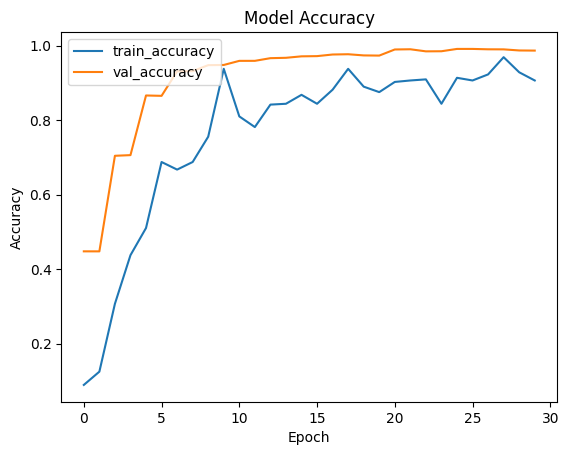

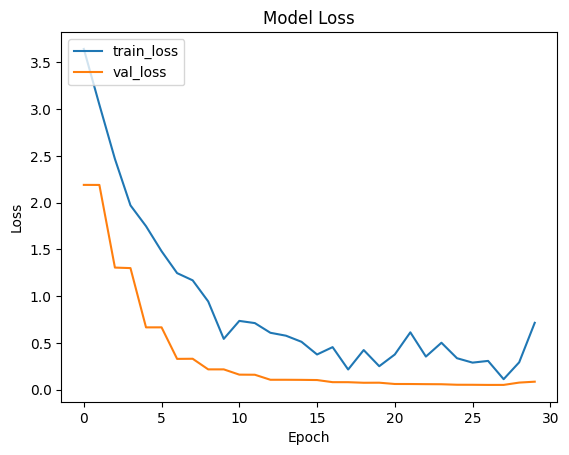

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f'Test accuracy: {test_acc}')

605/605 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9899 - loss: 0.0510
Test accuracy: 0.9898707866668701


##Classification Report

In [ ]:
# Get model predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred_classes))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_classes))

605/605 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       435
           1       0.93      1.00      0.96       454
           2       0.96      0.95      0.95       446
           3       0.98      0.98      0.98       425
           4       1.00      0.98      0.99       484
           5       0.96      0.85      0.90       449
           6       1.00      1.00      1.00       475
           7       0.93      0.99      0.96       445
           8       0.89      0.91      0.90       455
           9       0.98      1.00      0.99       458
          10       1.00      0.98      0.99       434
          11       1.00      0.99      0.99       470
          12       1.00      1.00      1.00       443
          13       1.00      1.00      1.00       455
          14       1.00      1.00      1.00       411
          15       1.00      1.00      1.00       466
          16    

##Confusion Matrix

605/605 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step


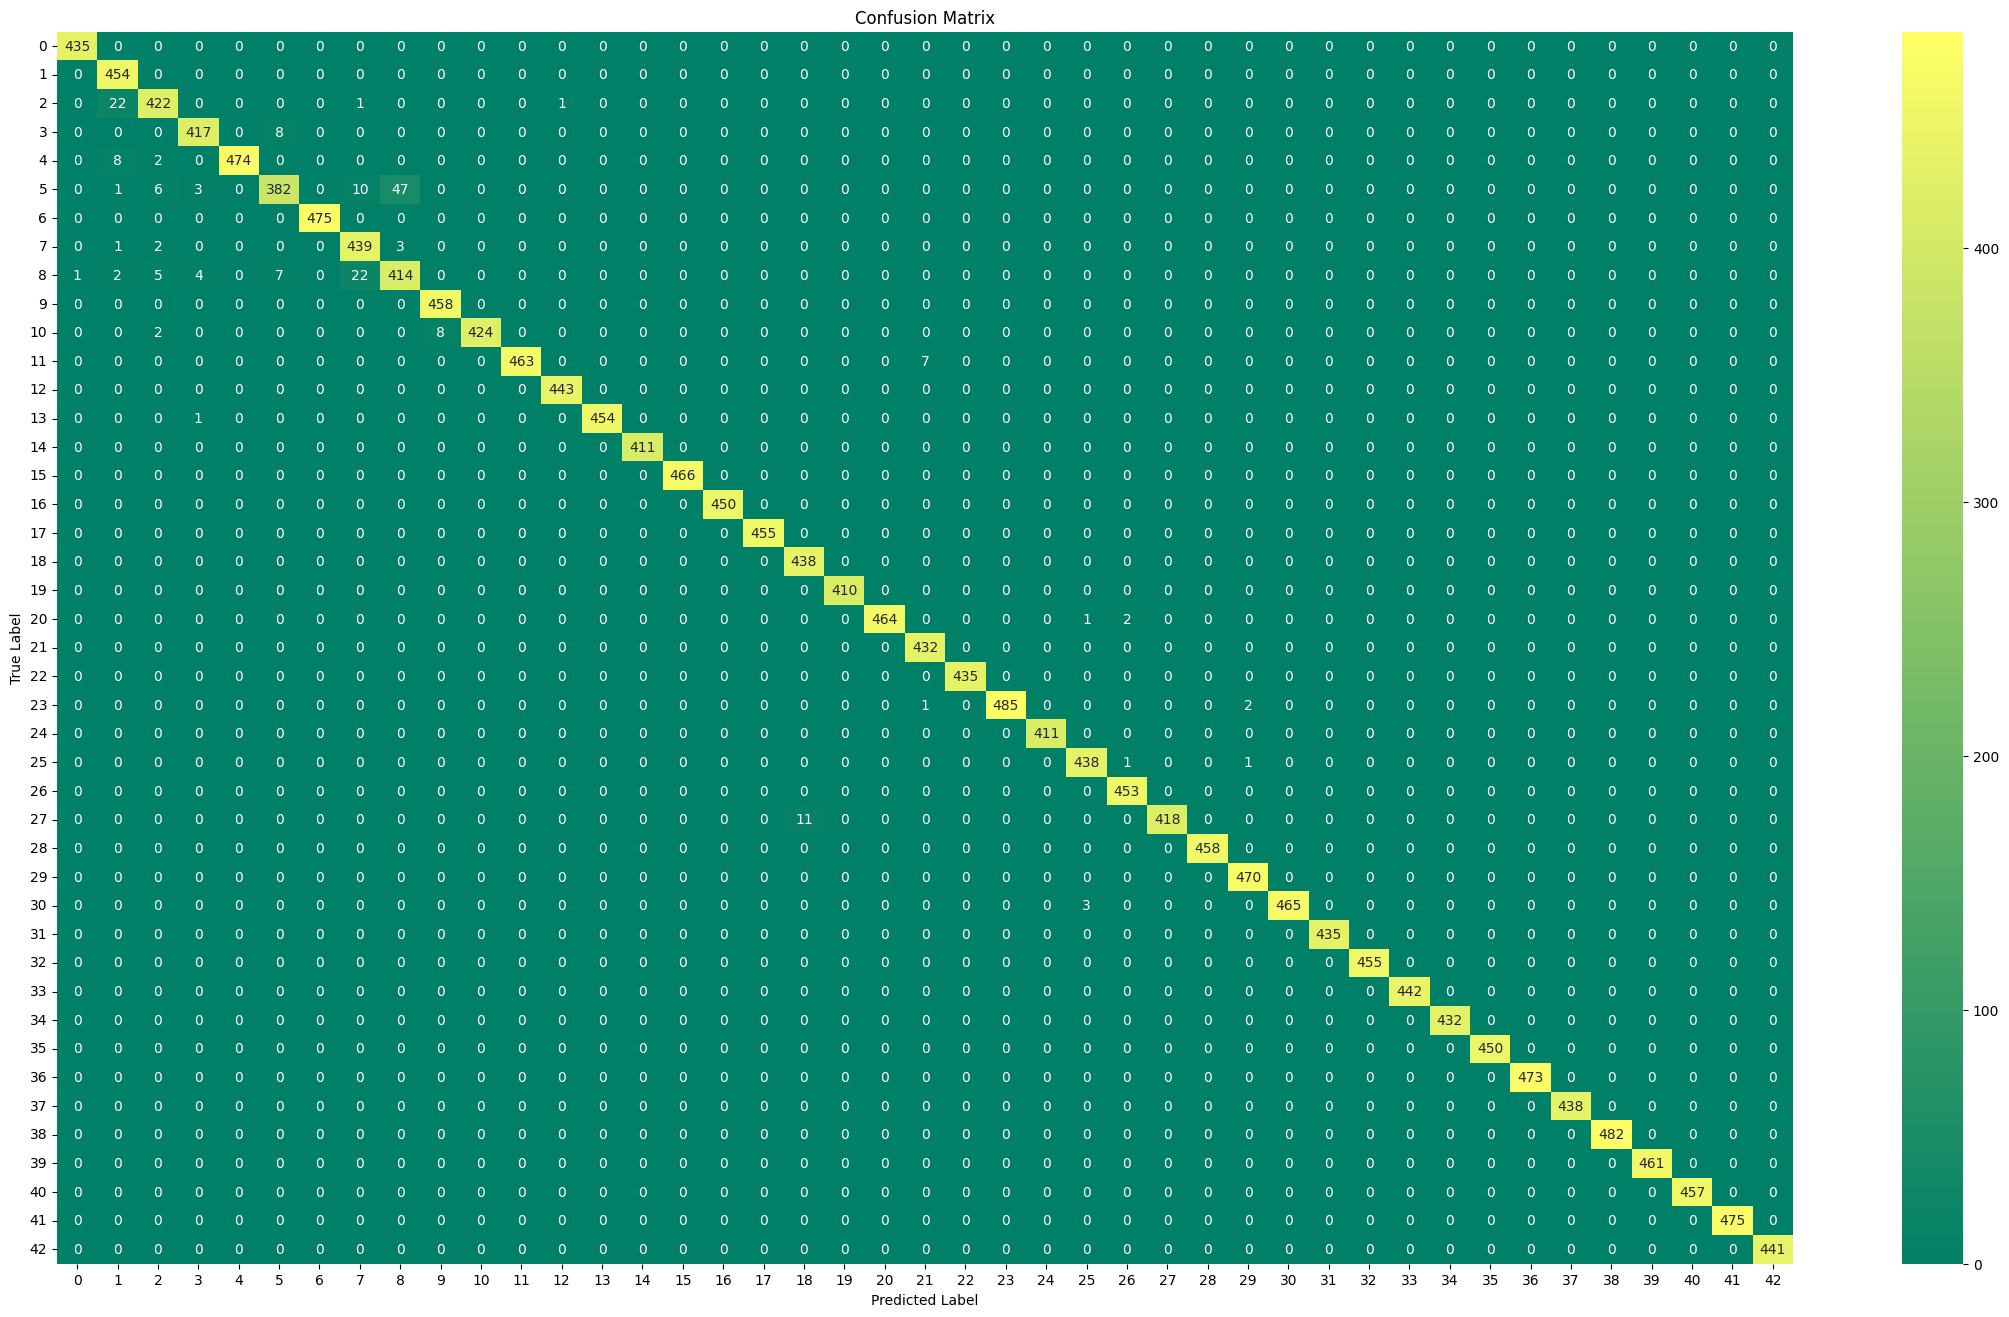

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get model predictions
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Visualize it using seaborn's heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='summer')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.yticks(rotation = 0)
plt.title('Confusion Matrix')
plt.show()

#Evaluate on test data (unseen data)

In [ ]:
# Path to test CSV file
test_csv_path = '/content/drive/My Drive/Data/GTSRB/Test/GTSRB/Final_Test/Images/GT-final_test.test.csv'
# Load the test labels from the CSV file
test_data = pd.read_csv(test_csv_path, sep=";")

In [ ]:
# Predict the class probabilities
predictions = model.predict(X_test)

# Get the class index with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


##Save test data

In [ ]:
# Create a DataFrame to save the image file names and predicted classes
result_df = pd.DataFrame({
    'Filename': test_img_names,
    'Predicted Class': predicted_classes
})

# Ensure the filenames are sorted in ascending order in the result file
result_df = result_df.sort_values(by='Filename')

# Save the results to a CSV file
result_df.to_csv('gtsrb_test_predictions.csv', index=False)
print("Predictions saved to 'gtsrb_test_predictions.csv'")

Predictions saved to 'gtsrb_test_predictions.csv'


##Print test accuracy

In [ ]:
import pandas as pd

# Load your predictions
predictions_df = pd.read_csv('gtsrb_test_predictions.csv')

# Load the ground truth file (downloaded separately)
ground_truth_df = pd.read_csv('/content/drive/My Drive/Data/GTSRB/GT-final_test.csv', sep=';')

# Merge both dataframes on the 'Filename' column
merged_df = pd.merge(predictions_df, ground_truth_df[['Filename', 'ClassId']], on='Filename')

# Calculate accuracy by comparing predicted classes with actual classes
accuracy = (merged_df['Predicted Class'] == merged_df['ClassId']).mean()

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 93.48%
